<a href="https://colab.research.google.com/github/franciscogarate/cdiae/blob/main/notebooks/11_Bootstrap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cálculo de la media y varianza valiéndose de la técnica de remuestreo (bootstrap) obteniendo 10000 $\overline{s}$.

En el anexo XVII del Reglamento Delegado, figuran los requisitos y demostraciones que deben realizarse para la aprobación de parámetros específicos de empresa. Entre ellos, se debe demostrar que la siniestralidad agregada sigue una distribución logarítmica normal $LN(\mu,\sigma)$.
Se pide, partiendo de los siniestros recogidos en el fichero *siniestralidad_agregada.csv*:


Importamos las librerías que vamos a necesitar

In [11]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

Cargamos el fichero de siniestralidad agregada

In [12]:
#!git clone https://github.com/franciscogarate/cdiae

In [13]:
df = pd.read_csv('cdiae/data/01_raw/siniestralidad_agregada.csv', sep=';', decimal=',')
df.head()

,Id,Importe
0,0,41.27
1,1,155.30
2,2,259.44
3,3,106.53
4,4,232.71


Calculamos la siniestralidad agregada (suma de importes)

In [14]:
siniestralidad_agregada = df['Importe'].sum()
print(f'Siniestralidad agregada: {siniestralidad_agregada:,.0f}')

Siniestralidad agregada: 3,059,720


Aplicamos bootstrap: generamos 10000 remuestreos de la siniestralidad total, así obtenemos muchas réplicas de la suma de los siniestros.
Posteriormente, pasamos esas sumas a escala logarítmica y calculamos la media y desviación típica de esos logaritmos, que servirán después para ajustar una Lognormal 
$LN(\mu,\sigma)$.

In [15]:
n = df.Importe.count()
b = 10000

sampling = pd.DataFrame(data=np.zeros(b),columns=['s'])
for i in range(b):
    sample = df.sample(n, replace=True)
    summ = sample['Importe'].sum()
    sampling.loc[i, 's'] = summ

sampling['z'] = np.log(sampling['s'])
boot_mean = sampling['z'].mean()
boot_std = sampling['z'].std()

Mostramos los parámetros estimados de la distribución lognormal, que serían nuestras variables candidatas LN(mu=boot_mean, sigma=boot_stp)

In [16]:
print(boot_mean, boot_std)

14.933761251743556 0.005006913202761923


Creamos la distribución lognormal teórica y graficamos su CDF

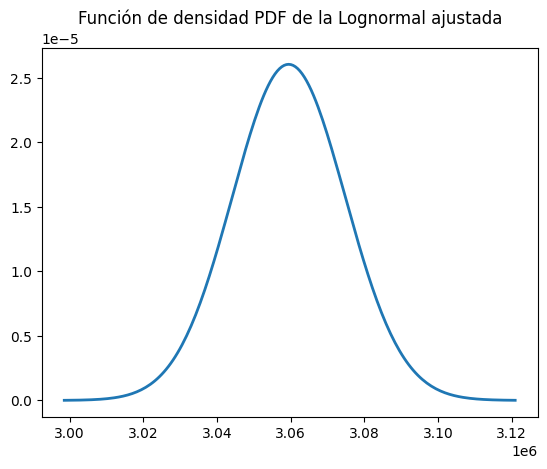

In [17]:
mu = boot_mean
sigma = boot_std
lognormal = st.lognorm(s=sigma, scale=np.exp(mu))

x = np.linspace(siniestralidad_agregada * 0.98,
                siniestralidad_agregada * 1.02, 200)

# Pintamos la PDF
plt.plot(x, lognormal.pdf(x), linewidth=2)
plt.title("Función de densidad PDF de la Lognormal ajustada")
plt.show()

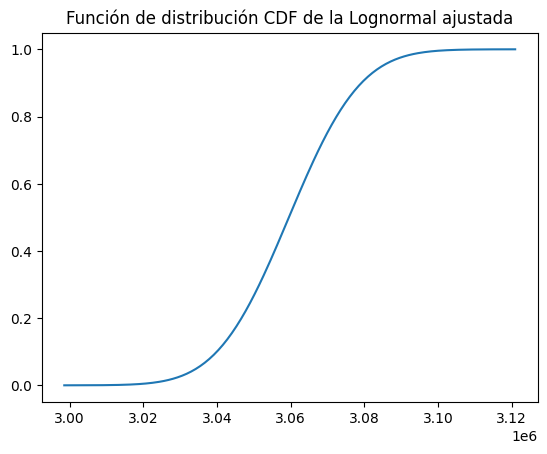

In [18]:
plt.plot(x, lognormal.cdf(x))
plt.title("Función de distribución CDF de la Lognormal ajustada")
plt.show()

### Cálculo de  los principales percentiles (.25, .5, 0.75, 0.90, 0.95) de la distribución teórica y compararlos con los datos de la distribución empírica de los siniestros.

NOTA: siendo s la siniestralidad total y z la variable aleatoria normal, entonces $s = e^{z}$ y $z = log(s)$ con media y varianza:

$E(s) = e^{\mu+\frac{\sigma^2}{2}}$

$Var(s) = (e^{\sigma^2} -1) e^{2\mu+\sigma^2}$

Comparamos percentiles teóricos vs empíricos de s

In [19]:
emp_q = sampling['s'].quantile([0.25, 0.5, 0.75, 0.90, 0.95])

# Percentiles teóricos de la lognormal ajustada
p = np.array([0.25, 0.50, 0.75, 0.90, 0.95])
theo_q = st.lognorm.ppf(p, s=sigma, scale=np.exp(mu))

pct_table = pd.DataFrame({
    'p': p,
    'empirico_s': emp_q.values,
    'teorico_s': theo_q
})

pct_table.round(5)

,p,empirico_s,teorico_s
0,0.25,3.049202e+06,3.049183e+06
1,0.50,3.059469e+06,3.059498e+06
2,0.75,3.069834e+06,3.069847e+06
3,0.90,3.079084e+06,3.079192e+06
4,0.95,3.084983e+06,3.084798e+06


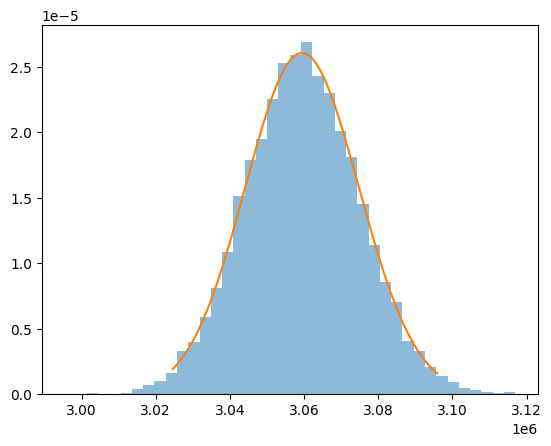

In [20]:
xmin = sampling['s'].quantile(0.01)
xmax = sampling['s'].quantile(0.99)
xs = np.linspace(xmin, xmax, 400)

# Histograma de densidad de s
plt.hist(sampling['s'], bins=40, density=True, alpha=0.5)
# PDF teórica
pdf = st.lognorm.pdf(xs, s=sigma, scale=np.exp(mu))
plt.plot(xs, pdf)
plt.show()